Generate some validation videos random, download them from the server and then use them to visualize the results.

In [1]:
import random
import os
import numpy as np
from work.dataset.activitynet import ActivityNetDataset

dataset = ActivityNetDataset(
    videos_path='../dataset/videos.json',
    labels_path='../dataset/labels.txt'
)
videos = dataset.get_subset_videos('validation')
videos = random.sample(videos, 8)

examples = []
for v in videos:
    file_dir = os.path.join('../downloads/features/', v.features_file_name)
    if not os.path.isfile(file_dir):
        os.system('scp imatge:~/work/datasets/ActivityNet/v1.3/features/{} ../downloads/features/'.format(v.features_file_name))
    features = np.load(file_dir)
    examples.append((v, features))

Load the trained model with its weigths

In [2]:
from keras.layers import Input, BatchNormalization, LSTM, TimeDistributed, Dense
from keras.models import Model

input_features = Input(batch_shape=(1, 1, 4096,), name='features')
input_normalized = BatchNormalization(mode=1)(input_features)
lstm1 = LSTM(512, return_sequences=True, stateful=True, name='lstm1')(input_normalized)
lstm2 = LSTM(512, return_sequences=True, stateful=True, name='lstm2')(lstm1)
output = TimeDistributed(Dense(201, activation='softmax'), name='fc')(lstm2)
model = Model(input=input_features, output=output)
model.load_weights('../work/scripts/training/lstm_activity_classification/model_snapshot/lstm_activity_classification_02_e100.hdf5')
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
features (InputLayer)              (1, 1, 4096)        0                                            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormaliz(1, 1, 4096)        8192        features[0][0]                   
____________________________________________________________________________________________________
lstm1 (LSTM)                       (1, 1, 512)         9439232     batchnormalization_1[0][0]       
____________________________________________________________________________________________________
lstm2 (LSTM)                       (1, 1, 512)         2099200     lstm1[0][0]                      
___________________________________________________________________________________________

Extract the predictions for each video and print the scoring

In [3]:
predictions = []
for v, features in examples:
    nb_instances = features.shape[0]
    X = features.reshape((nb_instances, 1, 4096))
    model.reset_states()
    prediction = model.predict(X, batch_size=1)
    prediction = prediction.reshape(nb_instances, 201)
    class_prediction = np.argmax(prediction, axis=1)
    predictions.append((v, prediction, class_prediction))

/Users/Alberto/Development/DeepLearning/frameworks/Keras/keras/keras/backend/theano_backend.py:514: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


Print the global classification results

Video ID: unI7FhokvbM		Ground truth: Installing carpet
0.5446	Vacuuming floor
0.1337	Ironing clothes
0.0953	Doing nails


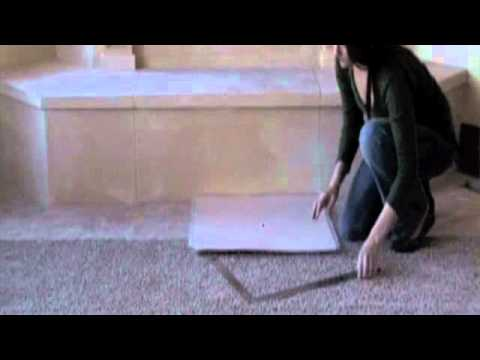



Video ID: 7p99ez6MEeo		Ground truth: Volleyball
0.7736	Playing beach volleyball
0.1720	Playing kickball
0.0376	Volleyball


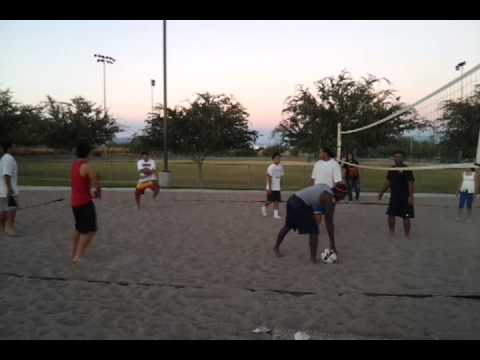



Video ID: E50qKeeMbgU		Ground truth: Elliptical trainer
0.6777	Elliptical trainer
0.2239	Assembling bicycle
0.0558	Spinning


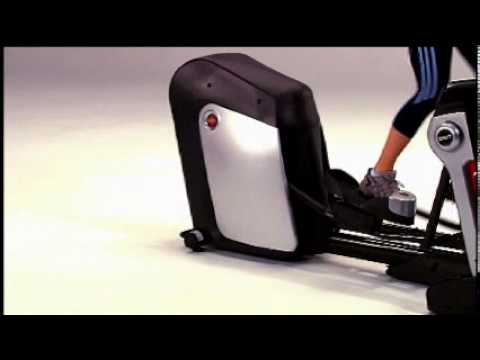



Video ID: j56eH9M0ObY		Ground truth: Breakdancing
0.4643	Breakdancing
0.2776	Tango
0.2189	Belly dance


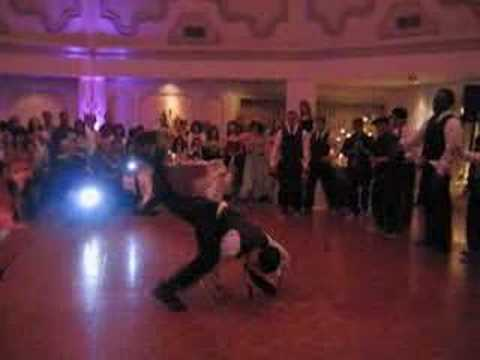



Video ID: CRzaKuaCXr8		Ground truth: Cumbia
0.5613	Breakdancing
0.1487	Brushing teeth
0.0881	Snatch


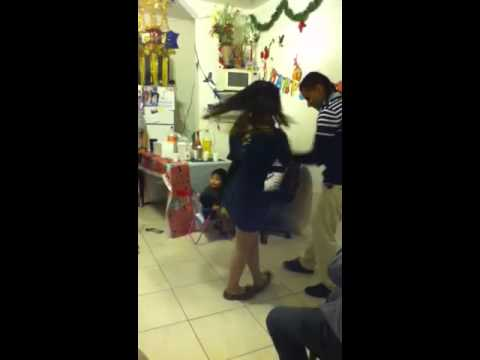



Video ID: DP9hfhq8sro		Ground truth: Table soccer
0.5665	Painting furniture
0.1129	Laying tile
0.1023	Paintball


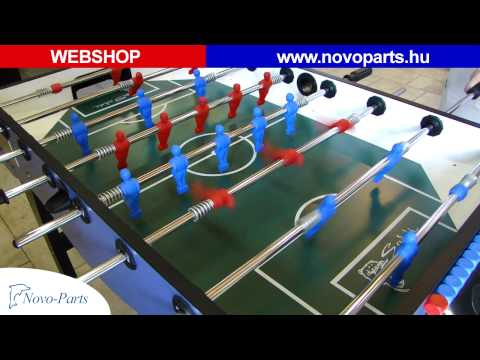



Video ID: xSWpGhhM1H8		Ground truth: Tug of war
0.9300	Tug of war
0.0140	Rafting
0.0082	Hitting a pinata


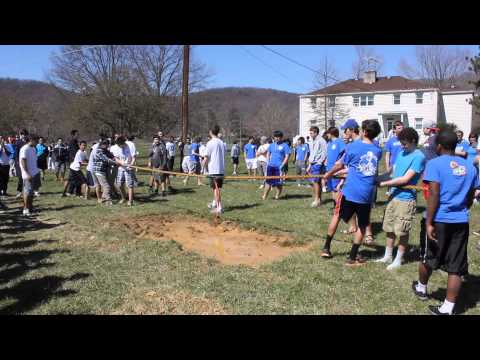



Video ID: WQmJrfjOF7o		Ground truth: Laying tile
0.5013	Installing carpet
0.2710	Laying tile
0.2099	Vacuuming floor


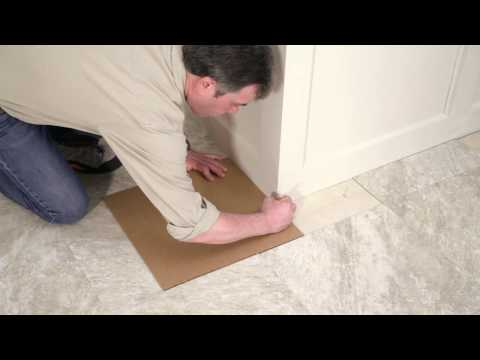

In [9]:
from IPython.display import YouTubeVideo, display

for v, prediction, class_prediction in predictions:
    print('Video ID: {}\t\tGround truth: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    vid = YouTubeVideo(v.video_id)
    display(vid)
    print('\n')
    
    

Now show the temporal prediction for the activity happening at the video.

Video ID: unI7FhokvbM
Main Activity: Installing carpet


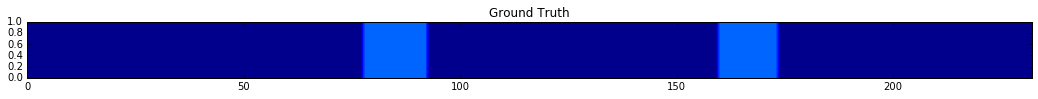

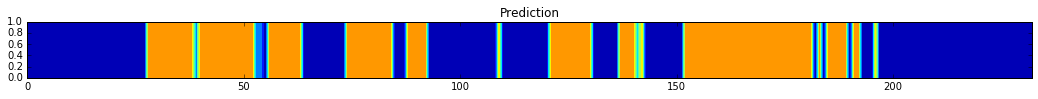



Video ID: 7p99ez6MEeo
Main Activity: Volleyball


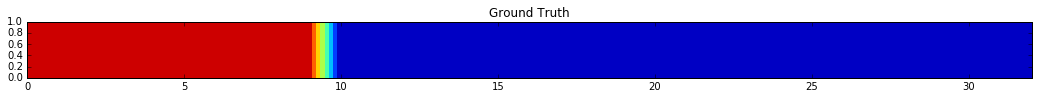

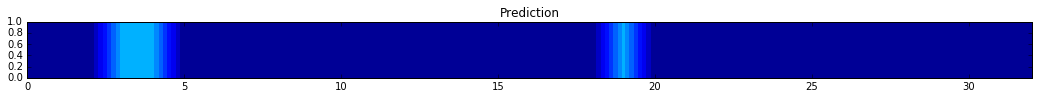



Video ID: E50qKeeMbgU
Main Activity: Elliptical trainer


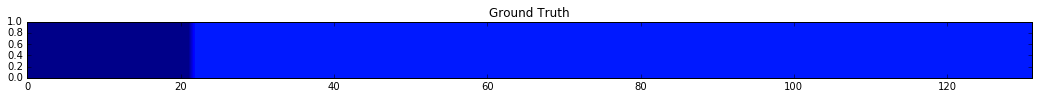

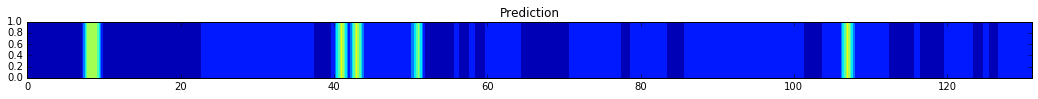



Video ID: j56eH9M0ObY
Main Activity: Breakdancing


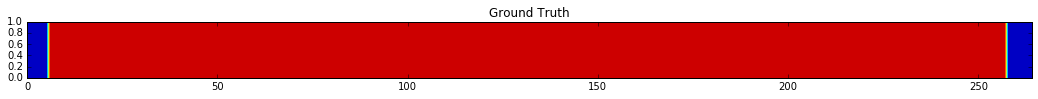

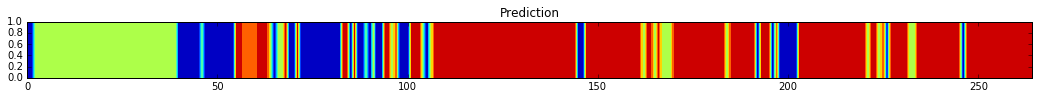



Video ID: CRzaKuaCXr8
Main Activity: Cumbia


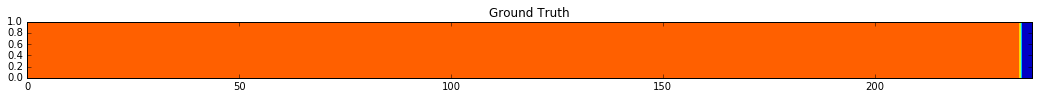

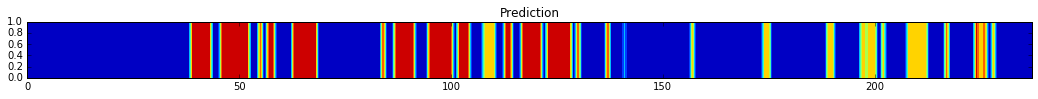



Video ID: DP9hfhq8sro
Main Activity: Table soccer


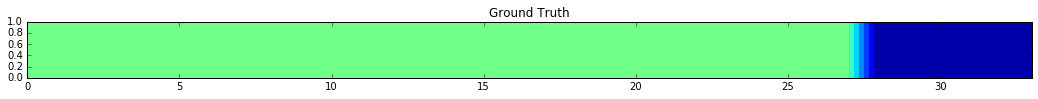

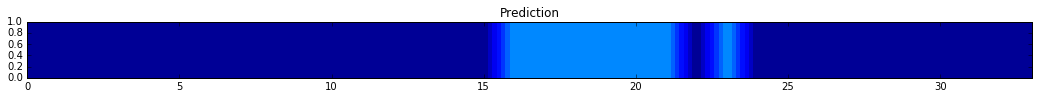



Video ID: xSWpGhhM1H8
Main Activity: Tug of war


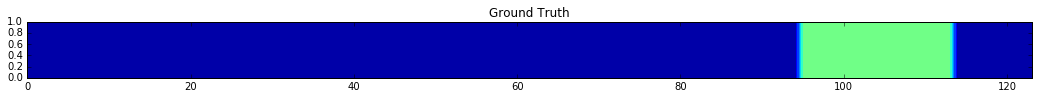

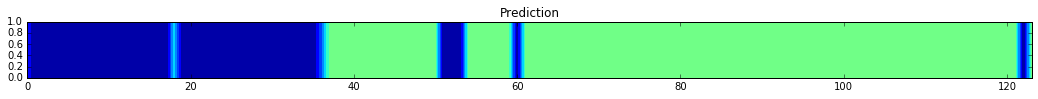



Video ID: WQmJrfjOF7o
Main Activity: Laying tile


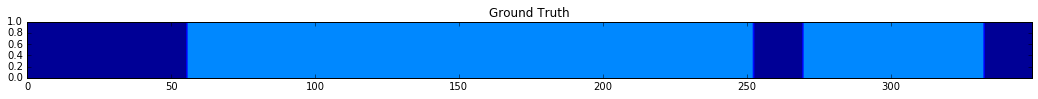

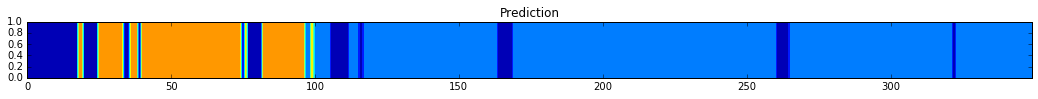

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
normalize = matplotlib.colors.Normalize(vmin=0, vmax=201)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction')
    plt.show()

    print('\n')

Video ID: unI7FhokvbM
Main Activity: Installing carpet
0.5446	Vacuuming floor
0.1337	Ironing clothes
0.0953	Doing nails


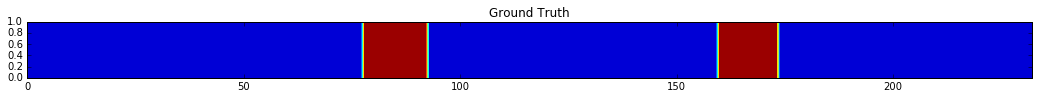

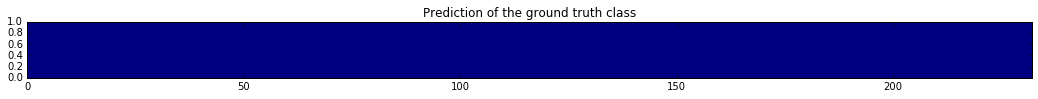

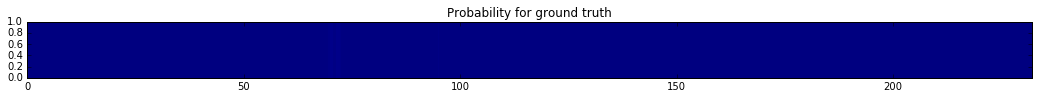



Video ID: 7p99ez6MEeo
Main Activity: Volleyball
0.7736	Playing beach volleyball
0.1720	Playing kickball
0.0376	Volleyball


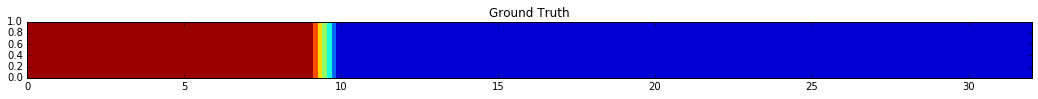

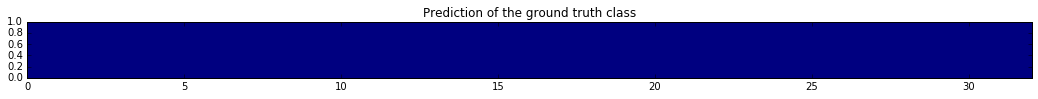

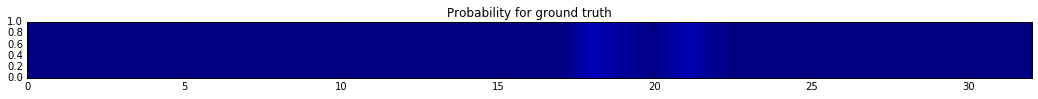



Video ID: E50qKeeMbgU
Main Activity: Elliptical trainer
0.6777	Elliptical trainer
0.2239	Assembling bicycle
0.0558	Spinning


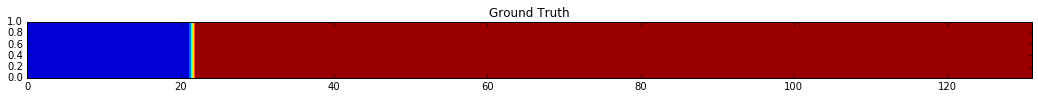

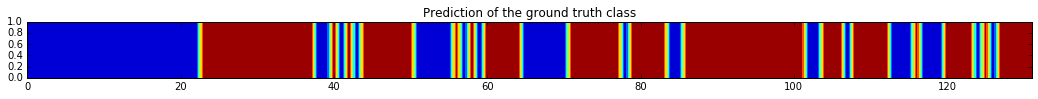

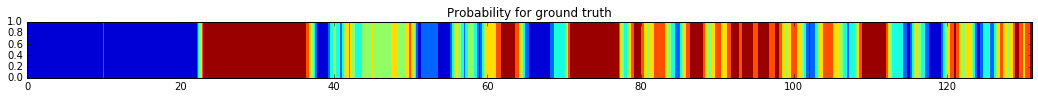



Video ID: j56eH9M0ObY
Main Activity: Breakdancing
0.4643	Breakdancing
0.2776	Tango
0.2189	Belly dance


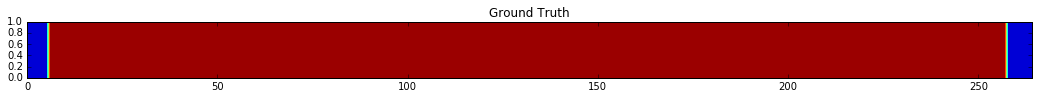

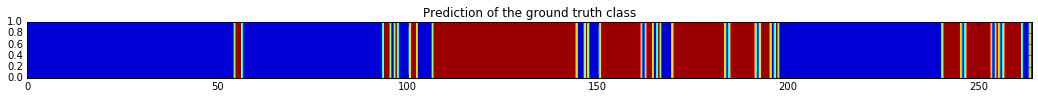

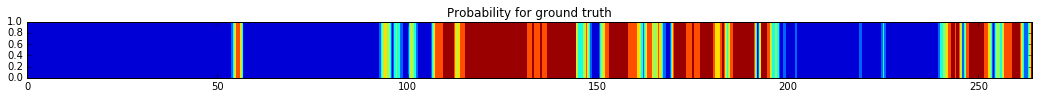



Video ID: CRzaKuaCXr8
Main Activity: Cumbia
0.5613	Breakdancing
0.1487	Brushing teeth
0.0881	Snatch


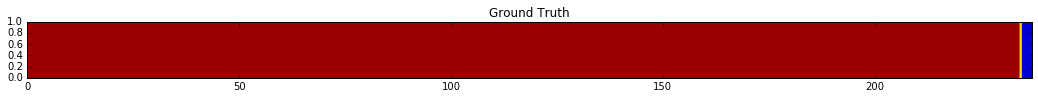

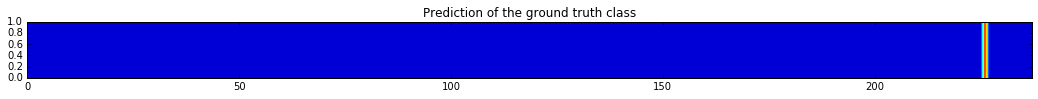

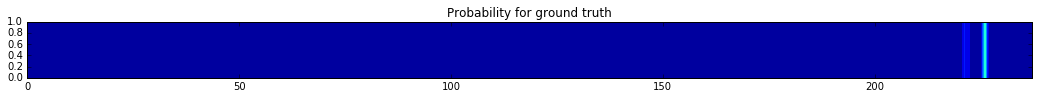



Video ID: DP9hfhq8sro
Main Activity: Table soccer
0.5665	Painting furniture
0.1129	Laying tile
0.1023	Paintball


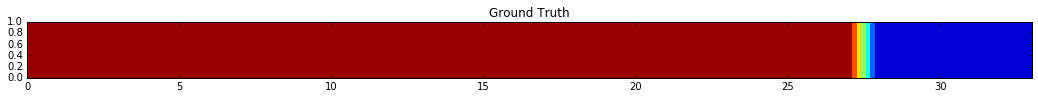

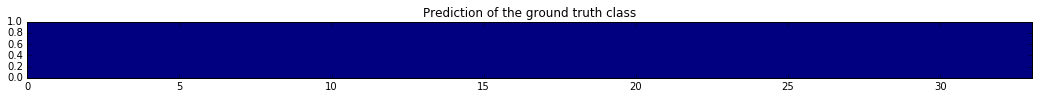

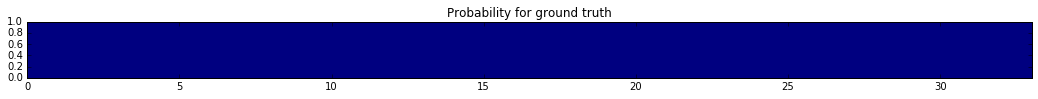



Video ID: xSWpGhhM1H8
Main Activity: Tug of war
0.9300	Tug of war
0.0140	Rafting
0.0082	Hitting a pinata


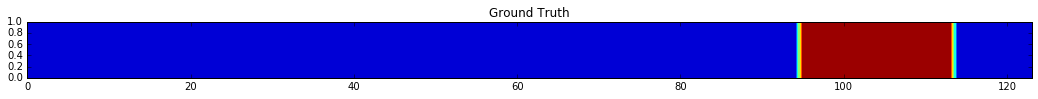

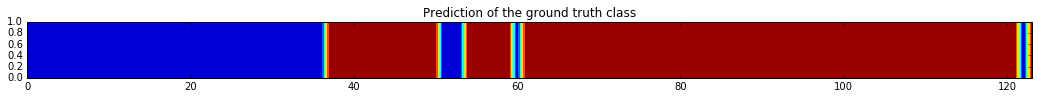

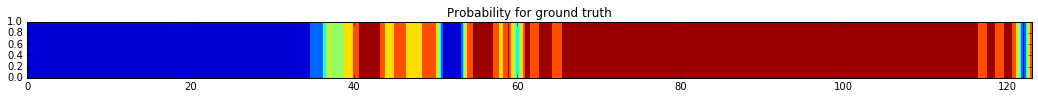



Video ID: WQmJrfjOF7o
Main Activity: Laying tile
0.5013	Installing carpet
0.2710	Laying tile
0.2099	Vacuuming floor


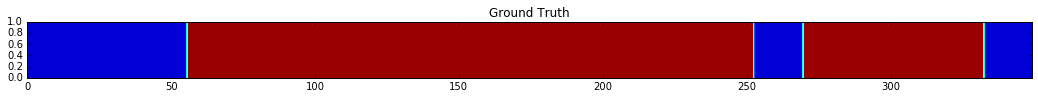

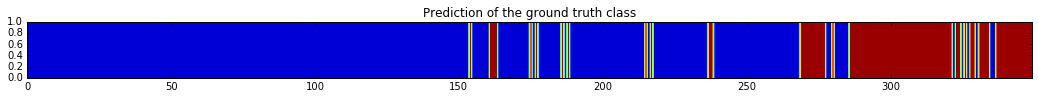

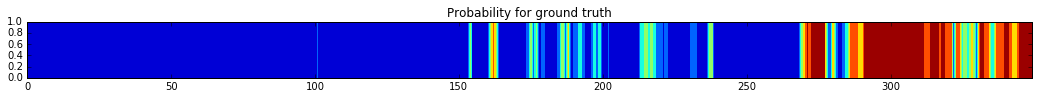

In [8]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    output_index = dataset.get_output_index(v.label)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))

    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth/output_index, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    # print only the positions that predicted the global ground truth category
    temp = np.zeros((nb_instances))
    temp[class_prediction==output_index] = 1
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(temp, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction of the ground truth class')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(prediction[:,output_index], (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Probability for ground truth')
    plt.show()

    print('\n')